In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys

from astropy import units as u
from astropy import constants as c
from astropy.cosmology import Planck18 as cosmo
import numpy as np

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

sys.path.append(os.environ['DM21CM_DIR'])
from dm21cm.preprocessing.hmf import *

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file("../../plotting/matplotlibrc")

Some of these are my choice. Some of these are hardcoded by `21cmFAST`.

# 1. Window functions

Sphere:

$$W(\vec k, R)=\int d^3x~e^{-i\vec k\vec x} \frac{3}{4\pi R^3} = \frac{3(\sin(k R)-kR\cos(kR))}{(kR)^3}$$
Normalization
$$W(0, R)=1$$

Cube:

$$W(\vec k, R)=\left(\int_{-R}^R dx~e^{-i k_x x} \frac{1}{2R}\right)(x\rightarrow y)(x\rightarrow z)=\frac{\sin(k_x R)}{k_x R}\frac{\sin(k_y R)}{k_y R}\frac{\sin(k_z R)}{k_z R}$$
Normalization
$$W(0, R)=1$$

# 2. Generating and normalize power spectrum from EH

In [2]:
ps = NormalizedPowerSpectrum()
radius_8 = 8.0/cosmo.h

# sigma_8^2
print(cosmo.to_format('mapping')['meta']['sigma8']**2)

# sphere trapz integral check
k = jnp.geomspace(ps.k_s[0], ps.k_s[-1], 10000)
print(float(jnp.trapz(ps.k2P(k) * ps.window.W(k, radius_8)**2, k)))

0.6564240400000001
0.656340298729917


In `Transfer(z=0)`, let $T=$ `np.exp(self._unnormalised_lnT)`. $k=$ `self.k`. $n=$ `self.n`.

`self.power` $=P(k)=$ `self._normalisation**2` $k^n\,T^2$ \
`self.delta_k` $=\Delta^2(k)=k^3 * P(k) / (2 \pi)$

$$\sigma^2_8=\frac{1}{2\pi^2}\int dk\, k^2 P(k) W(k, R)^2$$

Here:

`self.transfer_function` $\propto T$

`interp_P` $= C k^2 \cdot k^{n'} \,T^2=C k^2 P(k)$, where $C$ is a unknown normalization. \
But it doesn't matter, we only care that for some normalization $C$,
$$\sigma^2_8 \equiv \int dk~ \Big(C k^2P(k)\Big) W(k, R)^2$$
So that later $\sigma^2(M)$ can be obtained in the exact same way.
Here `k2P` is $C k^2P(k)$ with unknown normalization $C$.

## 2.1 Check cube $\sigma_8$ is not crazy

$$\sigma^2 = \int dk~ \Big(C k^2P(k)\Big) W_\circ(k, R)^2 = \int d^3\vec k~ \frac{1}{4\pi |\vec k|^2}\Big(C |\vec k|^2P(|\vec k|)\Big) W_\square(\vec k, R)^2$$

In [3]:
wc = CubeWindow()

class CISigmaSq (CubeIntegrator):
    def integrand(self, kx, ky, kz, R):
        k = jnp.sqrt(kx**2 + ky**2 + kz**2)
        return ps.k2P(k) / (4*jnp.pi*k**2) * wc.W(kx, ky, kz, R)**2

In [4]:
# convergence
res_s = 2**np.arange(6, 12)
intg_s = []
for res in res_s:
    print(f"res = {res}")
    ci = CISigmaSq(ps.k_s, res=res, use_tqdm=True)
    intg_s.append(ci.integral(R=radius_8))
intg_s = jnp.asarray(intg_s)

res = 64


100%|██████████| 64/64 [00:00<00:00, 125.55it/s]


res = 128


100%|██████████| 128/128 [00:00<00:00, 135.83it/s]


res = 256


100%|██████████| 256/256 [00:00<00:00, 423.31it/s]


res = 512


100%|██████████| 512/512 [00:00<00:00, 715.68it/s]


res = 1024


100%|██████████| 1024/1024 [00:01<00:00, 849.11it/s] 


res = 2048


100%|██████████| 2048/2048 [00:07<00:00, 278.91it/s]


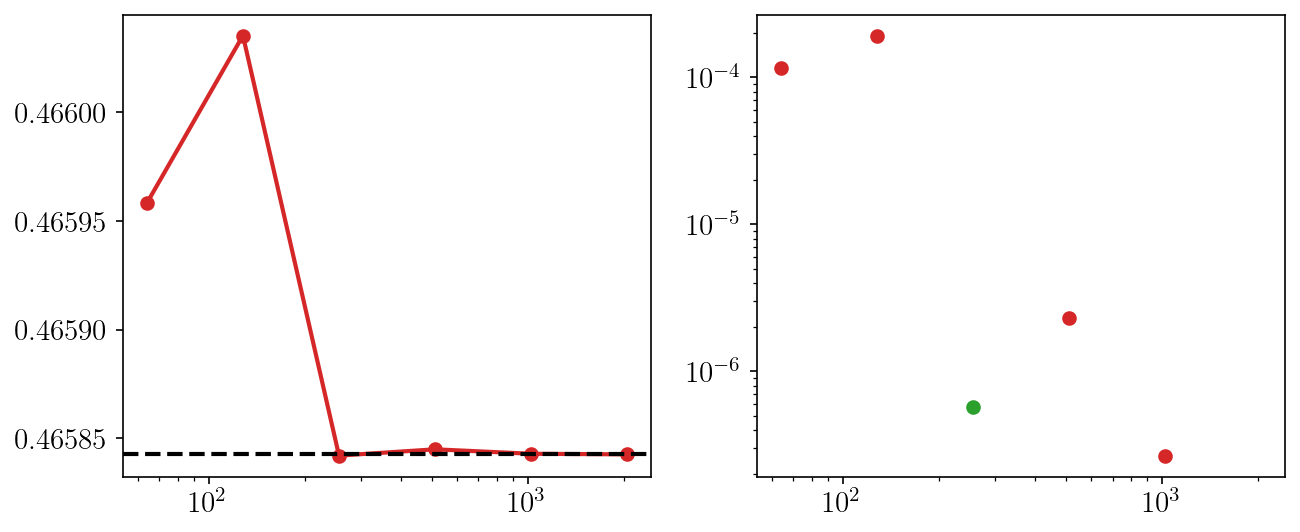

In [8]:
# convergence
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(res_s, intg_s, 'o-')
axs[0].axhline(intg_s[-1], color='k', linestyle='--')
axs[0].set(xscale='log')

axs[1].plot(res_s, (intg_s-intg_s[-1]), 'o')
axs[1].plot(res_s, -(intg_s-intg_s[-1]), 'o')
axs[1].set(xscale='log', yscale='log');

In [4]:
ci = CISigmaSq(ps.k_s, res=1024, use_tqdm=False)
print(' cube in sphere', ci.integral(R=radius_8/np.sqrt(3)))
print('         sphere', cosmo.to_format('mapping')['meta']['sigma8']**2)
print('Vcube = Vsphere', ci.integral(R=np.cbrt(np.pi/6) * radius_8))
print('sphere in cube', ci.integral(R=radius_8))

 cube in sphere 0.9795254402452758
         sphere 0.6564240400000001
Vcube = Vsphere 0.632314514279553
sphere in cube 0.4658429450395703


# 3. Operations on the Power Spectrum

In [13]:
smi_cube = SigmaMInterpCube(res=100)
smi_cube.compute_interps()
smi_cube.save("../../data/pwave/smi_cube_100.h5")

100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


In [3]:
smi_sphere = SigmaMInterpSphere()

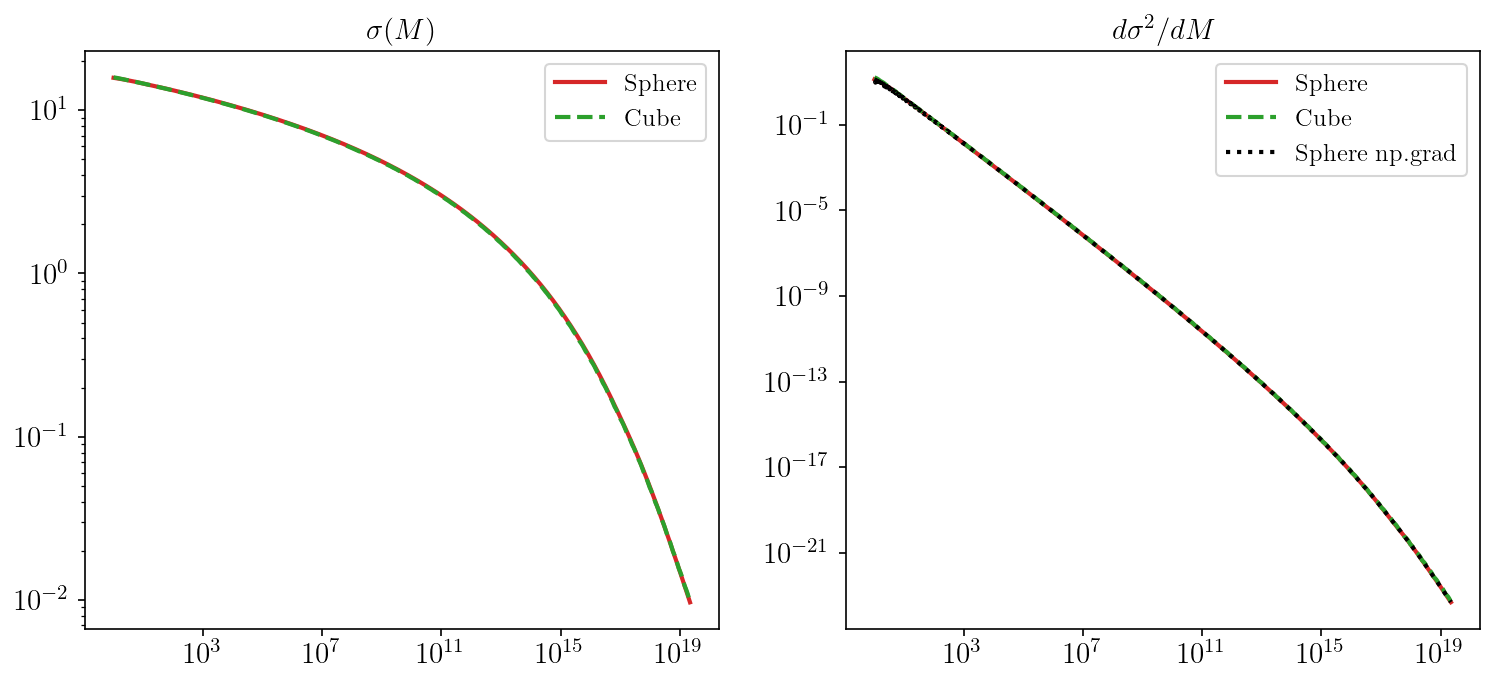

In [28]:
m_s = jnp.geomspace(M_MIN, M_MAX, 4001)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = axs[0]
sigma_sphere = np.array([smi_sphere.sigma_z0(m) for m in m_s])
grad_ssq_sphere = np.gradient(sigma_sphere**2, m_s)
sigma_cube = np.array([smi_cube.sigma_z0(m) for m in m_s])
grad_ssq_cube = np.gradient(sigma_cube**2, m_s)

ax.plot(m_s, sigma_sphere, label="Sphere")
ax.plot(m_s, sigma_cube, '--', label="Cube")
ax.set(xscale='log', yscale='log')
ax.set(title='$\sigma(M)$')
ax.legend()

ax = axs[1]
ax.plot(m_s, [-smi_sphere.dsigmasqdm_z0(m) for m in m_s], 'C0', label="Sphere")
ax.plot(m_s, [-smi_cube.dsigmasqdm_z0(m) for m in m_s], 'C1', ls='--', label="Cube")
ax.plot(m_s, - grad_ssq_sphere, 'k', ls=':', label="Sphere np.grad")
# ax.plot(m_s, - grad_ssq_cube, 'k', ls='-', lw=1, label="Cube np.grad")
ax.set(xscale='log', yscale='log')
ax.set(title='$d\sigma^2/dM$')
ax.legend()

# 4. Apply to Halo Annihilation Rates

In [6]:
ann_dict = load_h5_dict("../../data/pwave/ann_rates_zm.h5")

ann_z_s = ann_dict['z_range']
ann_m_s = ann_dict['m_range']
ann_rates = ann_dict['ann_rates'] # [M_sun(energy)^2 / pc^3 / Mpc^3]
# old (incorrect) annihilation rates
# ann_rates = ann_dict_old['annihilation_rates']

log10_interp = interpolate.RegularGridInterpolator(
    (ann_z_s, np.log10(ann_m_s)), np.log10(ann_rates),
    bounds_error=False, fill_value=np.min(np.log10(ann_rates))
)

def ann_interp(z, M):
    
    m_in = np.atleast_1d(M)
    z_in = np.full(m_in.shape, z)
    zm_in = np.stack([z_in, np.log10(m_in)], axis=-1)
    return 10**log10_interp(zm_in)

smi = SigmaMInterpSphere()
interpolated_annihilation_rates = np.zeros((len(ann_z_s), len(smi.m_s)))

for i, z in enumerate(tqdm(ann_z_s)):
    interpolated_annihilation_rates[i] = ann_interp(z, smi.m_s)

100%|██████████| 51/51 [00:00<00:00, 3558.28it/s]


In [7]:
# table range
z_range = ann_z_s
d_range = np.linspace(-1, 1.5, 128)
r_range = np.geomspace(0.1, 512, 128) # [cMpc]

In [8]:
# Conditional PS
hmfe = HMFEvaluator(smi_sphere)
ws = SphereWindow()

cond_dndm = np.zeros((len(z_range), len(d_range), len(r_range), len(smi.m_s)))

@jax.jit
@partial(jax.vmap, in_axes=(0, None, None))
def cond_dndm_func(r, d, z):
    return jnp.nan_to_num(hmfe.dNdM_Conditional(ws.RtoM(r), d, z))

for i, z in enumerate(tqdm(z_range)):
    for j, d in enumerate(d_range):
        cond_dndm[i, j, :] = cond_dndm_func(r_range, d, z)

cond_ann_table = np.zeros((len(z_range), len(d_range), len(r_range)))

for i in tqdm(range(cond_ann_table.shape[0])):
    for j in range(cond_ann_table.shape[1]):
        for k in range(cond_ann_table.shape[2]):
            cond_ann_table[i,j,k] = np.trapz(interpolated_annihilation_rates[i] * cond_dndm[i,j,k], smi.m_s)

del cond_dndm

100%|██████████| 51/51 [00:21<00:00,  2.33it/s]


In [9]:
# Unconditional PS
ps_ann_table = np.zeros((len(z_range)))

for i in range(ps_ann_table.shape[0]):
    ps_ann_table[i] = np.trapz(interpolated_annihilation_rates[i] * hmfe.dNdM(smi.m_s, z_range[i]), smi.m_s)

In [10]:
# Sheth-Tormen
st_ann_table = np.zeros((len(z_range)))

for i in range(st_ann_table.shape[0]):
    st_ann_table[i] = np.trapz(interpolated_annihilation_rates[i] * hmfe.dNdM_ST(smi.m_s, z_range[i]), smi.m_s)

# Save the Results

In [107]:
unity =  1 * (c.M_sun**2 * c.c**4 / (u.pc**3 * u.Mpc**3)).to(u.eV**2 / u.cm**3 / u.cm**3)
print(unity.value)

1441.3537210485738


In [108]:
table_dict = {
    'z_range' : z_range,
    'd_range' : d_range,
    'r_range' : r_range,
    'ps_cond_ann_rate_table' : cond_ann_table * unity.value,
    'ps_ann_rate_table' : ps_ann_table * unity.value,
    'st_ann_rate_table' : st_ann_table * unity.value,
    'table units' : 'eV^2 / cm^3 / cm^3',
}
save_dirs = [
    "/n/home07/yitians/dm21cm/DM21cm/data/pwave",
    "/n/holylabs/LABS/iaifi_lab/Users/yitians/dm21cm/data/zf002/data",
]
for save_dir in save_dirs:
    save_h5_dict(save_dir + f"/pwave_ann_rate_{smi.name}.h5", table_dict)

In [112]:
! ls /n/holylabs/LABS/iaifi_lab/Users/yitians/dm21cm/data/zf002/data

abscissas.h5  elec_scat.h5  phot_prop.h5  pwave_ann_rate_sphere.h5
elec_dep.h5   phot_dep.h5   phot_scat.h5


In [113]:
dNdM_table = []
dNdM_ST_table = []
for z in z_range:
    dNdM_table.append(hmfe.dNdM(smi.m_s, z))
    dNdM_ST_table.append(hmfe.dNdM_ST(smi.m_s, z))
dNdM_table = np.array(dNdM_table)
dNdM_ST_table = np.array(dNdM_ST_table)

ps_m_data = {
    'z_range': z_range,
    'm_range': smi.m_s,
    'm_range_units': 'Msun',
    'annihilation_rates': interpolated_annihilation_rates,
    'annihilation_rates_units': 'Msun^2 / pc^3',
    'dNdM': dNdM_table,
    'dNdM_ST': dNdM_ST_table,
    'dNdM_units': 'Msun^-1 Mpc^-3',
}

save_h5_dict('../../data/pwave/m_data.h5', ps_m_data)

# Archive

## A. Use old (incorrect) ann rate to match old results

In [101]:
ann_dict_old = np.load("../../data/pwave/Annihilation_Dictionary.npz", allow_pickle=True)
print(ann_dict_old.keys())

KeysView(NpzFile '../../data/pwave/Annihilation_Dictionary.npz' with keys: z_range, mass_range, annihilation_rates)


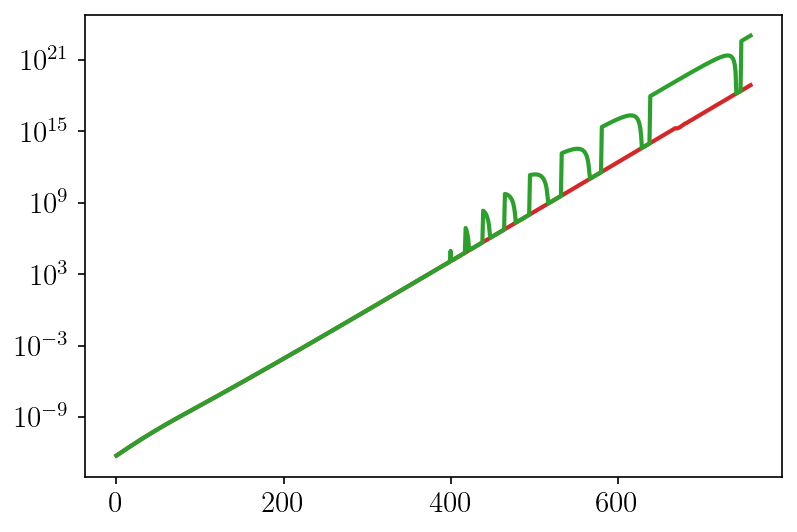

In [ ]:
plt.plot(ann_dict['ann_rates'][50])
plt.plot(ann_dict_old['annihilation_rates'][50])
plt.yscale('log')

In [ ]:
cmp = load_h5_dict("../../data/pwave/pwave_ann_rate_o.h5")
cmp.keys()

dict_keys(['delta_range', 'ps_ann_rate_table', 'ps_cond_ann_rate_table', 'r_range', 'st_ann_rate_table', 'z_range'])

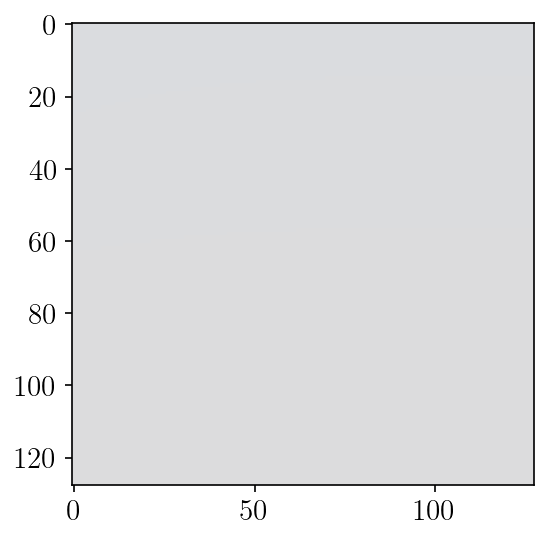

In [ ]:
i = 50
plt.imshow(cmp['ps_cond_ann_rate_table'][i] / table_dict['ps_cond_ann_rate_table'][i], cmap='coolwarm', vmin=0.5, vmax=1.5)

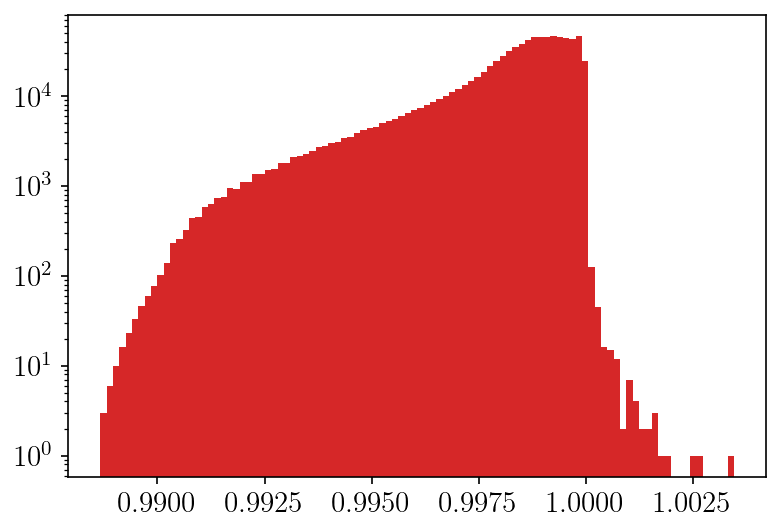

In [ ]:
z = cmp['ps_cond_ann_rate_table'] / table_dict['ps_cond_ann_rate_table']
plt.hist(z.flatten(), bins=100)
plt.yscale('log')

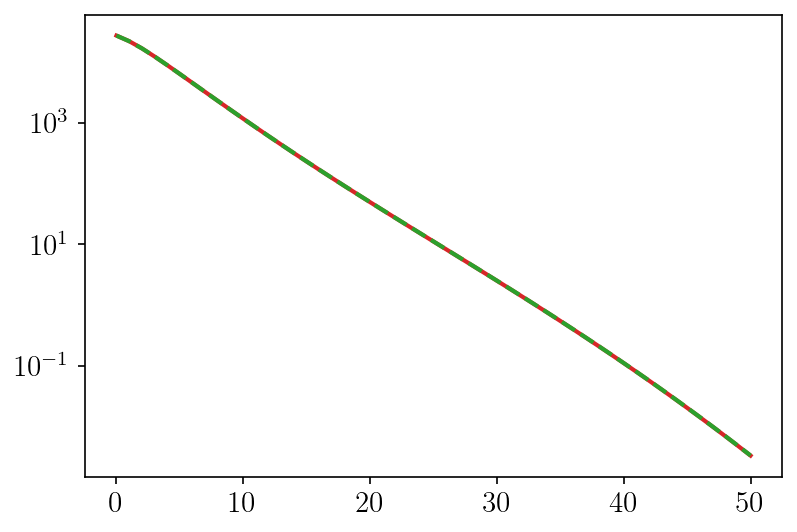

In [ ]:
plt.plot(cmp['z_range'], cmp['ps_ann_rate_table'])
plt.plot(table_dict['z_range'], table_dict['ps_ann_rate_table'], '--')
plt.yscale('log')

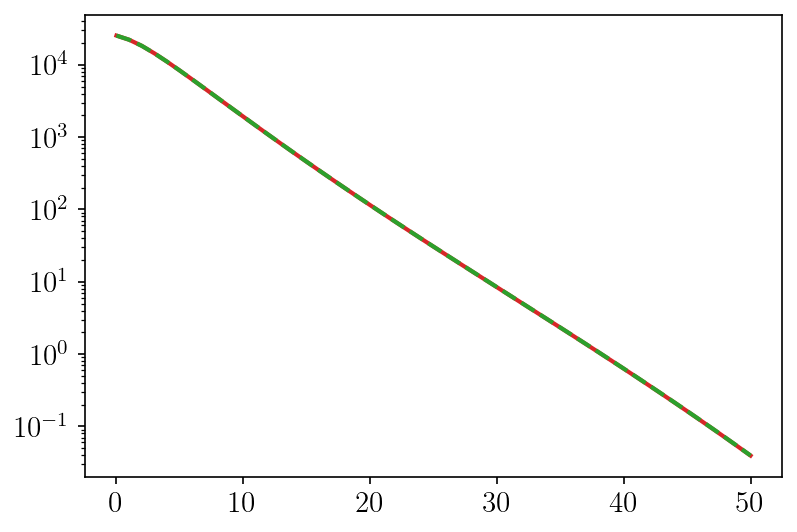

In [ ]:
plt.plot(cmp['z_range'], cmp['st_ann_rate_table'])
plt.plot(table_dict['z_range'], table_dict['st_ann_rate_table'], '--')
plt.yscale('log')

## B

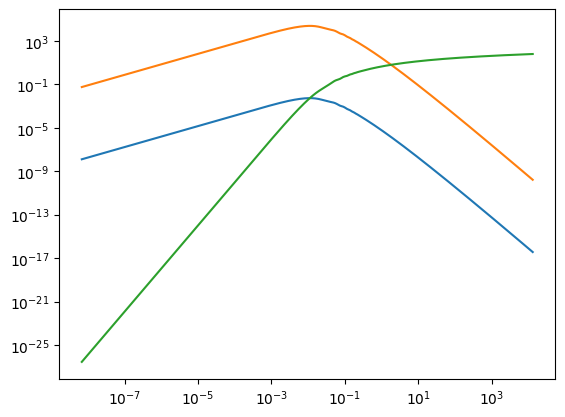

In [ ]:
interp_k = tr.k * cosmo.h # to u without `h`
interp_T = tr.transfer_function / np.amax(tr.transfer_function) # normalized
interp_P = interp_k**2 * interp_T**2 * interp_k**cosmo.to_format('mapping')['meta']['n']

plt.plot(interp_k, interp_P/interp_k**2)
plt.plot(interp_k, tr.power)
plt.plot(interp_k, tr.delta_k)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e0, None)

## C. Cube integration

In [ ]:
np.sqrt(10)

3.1622776601683795

In [ ]:
resolution = 10000
lklb = np.log(interp_k[0])
lkub = np.log(interp_k[-1])
lk_s = jnp.linspace(jnp.log(interp_k[0]), jnp.log(interp_k[-1]), resolution)
k_s = jnp.exp(lk_s)

def integrand_3(lkx, lky, lkz):
    kx, ky, kz = jnp.exp(lkx), jnp.exp(lky), jnp.exp(lkz)
    k = jnp.sqrt(kx**2 + ky**2 + kz**2)
    return kx * ky * kz * k2P_unnorm(k) * W(kx, ky, kz, Radius_8)**2

def integrand_2(lkx, lky):
    return jnp.trapz(k_s * integrand_3(lkx, lky, lk_s), lk_s)

@jit
def integrand_1(lkx):
    return jnp.trapz(k_s * vmap(integrand_2, (None, 0))(lkx, lk_s), lk_s)

def integral():
    integrand = []
    for lk in tqdm(lk_s):
        integrand.append(integrand_1(lk))
    integrand = jnp.asarray(integrand)
    return jnp.trapz(k_s * integrand, lk_s)

print(integral())

100%|██████████| 10000/10000 [11:17<00:00, 14.75it/s]


2.7448218808073346e-09


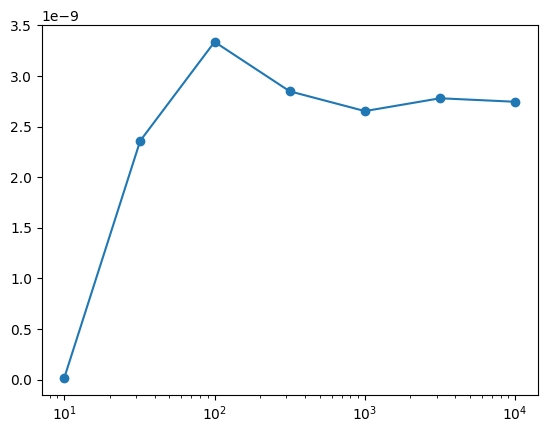

In [ ]:
a = [10, 32, 100, 316, 1000, 3162, 10000]
b = [1.8247880587527738e-11, 2.3588969428981962e-09, 3.3362717953372406e-09, 2.8484186491494225e-09, 2.6527731963891473e-09, 2.7794302923913358e-09, 2.7448218808073346e-09]
plt.plot(a, b, 'o-')
plt.xscale('log')